In [1]:
import numpy as np
seed = 71
np.random.seed = seed

import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import QuantumRegister, QuantumCircuit, BasicAer
from qiskit.circuit.library import TwoLocal, UniformDistribution

from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import QGAN
from qiskit.aqua.components.neural_networks import NumPyDiscriminator, PyTorchDiscriminator

aqua_globals.random_seed = seed

<ipython-input-1-75ecb621897c>:15: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  aqua_globals.random_seed = seed


In [2]:
# Number of samples
n = 1000

# Load samples
mu = 0
sigma = 1
real_data = np.random.lognormal(mean=mu, sigma=sigma, size=n)

# Set bounds
bounds = np.array([0., 3.])
num_qubits = [2]
k = len(num_qubits)

In [3]:
def setup_vars(num_qubits):
    # Entangler Map
    entangler_map = [[0,1]]
    
    # Set a state for the generator circuit
    init_dist = UniformDistribution(sum(num_qubits))

    # Set the ansatz circuit
    var_form = TwoLocal(int(np.sum(num_qubits)), 'ry', 'cz', entanglement=entangler_map, reps=1)
    
    # Set Generator's initial parameters
    init_params = np.random.rand(var_form.num_parameters_settable) * 2 * np.pi

    # Compose circuit
    g_circuit = var_form.compose(init_dist, front=True)

    return init_params, g_circuit

In [4]:
epochs = 20
batch_size = 100

# Quantum Instance
quantum_instance = QuantumInstance(backend=BasicAer.get_backend('statevector_simulator'),
                                   seed_transpiler=seed, seed_simulator=seed)

# Setup the circuit and its parameters
init_params, g_circuit = setup_vars(num_qubits)

# QGAN
qgan = QGAN(real_data, bounds, num_qubits, batch_size, epochs, snapshot_dir=None)
qgan.seed = 1

# Set generator
qgan.set_generator(generator_circuit=g_circuit, generator_init_params=init_params)
qgan._generator._free_parameters = sorted(g_circuit.parameters, key=lambda p: p.name)
# Set classical discriminator (numpy)
discriminator = PyTorchDiscriminator(len(num_qubits))
qgan.set_discriminator(discriminator)

/home/filipa/src/qc/qc/lib/python3.8/site-packages/qiskit/aqua/quantum_instance.py:135: DeprecationWarning: The class qiskit.aqua.QuantumInstance is deprecated. It was moved/refactored to qiskit.utils.QuantumInstance (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_class('aqua.QuantumInstance',
<ipython-input-3-b80513e25d6c>:6: DeprecationWarning: `UniformDistribution` is deprecated as of version 0.17.0 and will be removed no earlier than 3 months after the release date. It moved to qiskit_finance.circuit.library.UniformDistribution.
  init_dist = UniformDistribution(sum(num_qubits))
/home/filipa/src/qc/qc/lib/python3.8/site-packages/qiskit/aqua/algorithms/distribution_learners/qgan.py:103: DeprecationWarning: The package qiskit.aqua.algorithms.distribution_learners is deprecated. It was moved/refactored to qiskit_machine_learning.algorithms.distribution_learners (pip install qiskit-machine-learnin

In [5]:
result = qgan.run(quantum_instance)

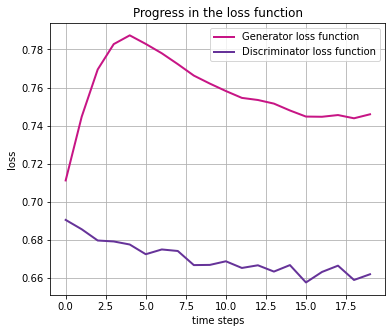

In [6]:
# Plot progress w.r.t the generator's and the discriminator's loss function
t_steps = np.arange(epochs)
plt.figure(figsize=(6,5))
plt.title("Progress in the loss function")
plt.plot(t_steps, qgan.g_loss, label='Generator loss function', color='mediumvioletred', linewidth=2)
plt.plot(t_steps, qgan.d_loss, label='Discriminator loss function', color='rebeccapurple', linewidth=2)
plt.grid()
plt.legend(loc='best')
plt.xlabel('time steps')
plt.ylabel('loss')
plt.show()

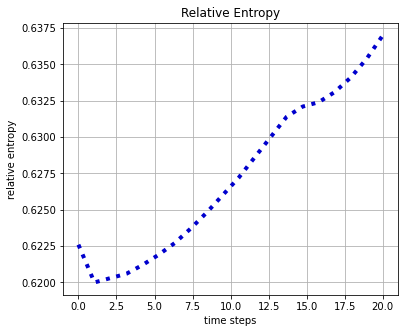

In [7]:
# Plot progress w.r.t relative entropy
plt.figure(figsize=(6,5))
plt.title('Relative Entropy')
plt.plot(np.linspace(0, epochs, len(qgan.rel_entr)), qgan.rel_entr, color='mediumblue', lw=4, ls=':')
plt.grid()
plt.xlabel('time steps')
plt.ylabel('relative entropy')
plt.show()

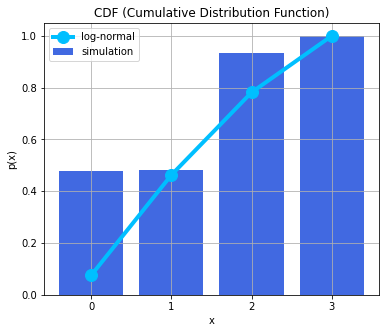

In [8]:
#Plot the CDF of the resulting distribution against the target distribution, i.e. log-normal
log_normal = np.random.lognormal(mean=1, sigma=1, size=100000)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= bounds[1]]
temp = []
for i in range(int(bounds[1] + 1)):
    temp += [np.sum(log_normal==i)]
log_normal = np.array(temp / sum(temp))

plt.figure(figsize=(6,5))
plt.title('CDF (Cumulative Distribution Function)')
samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)
samples_g = np.array(samples_g)
samples_g = samples_g.flatten()
num_bins = len(prob_g)
plt.bar(samples_g,  np.cumsum(prob_g), color='royalblue', width= 0.8, label='simulation')
plt.plot( np.cumsum(log_normal),'-o', label='log-normal', color='deepskyblue', linewidth=4, markersize=12)
plt.xticks(np.arange(min(samples_g), max(samples_g)+1, 1.0))
plt.grid()
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend(loc='best')
plt.show()